In [1]:
import pandas as pd

In [13]:
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/python-machine-learning-book-2nd-edition/master/code/ch10/housing.data.txt', 
                header=None, sep='\s+')

In [15]:
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

In [16]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


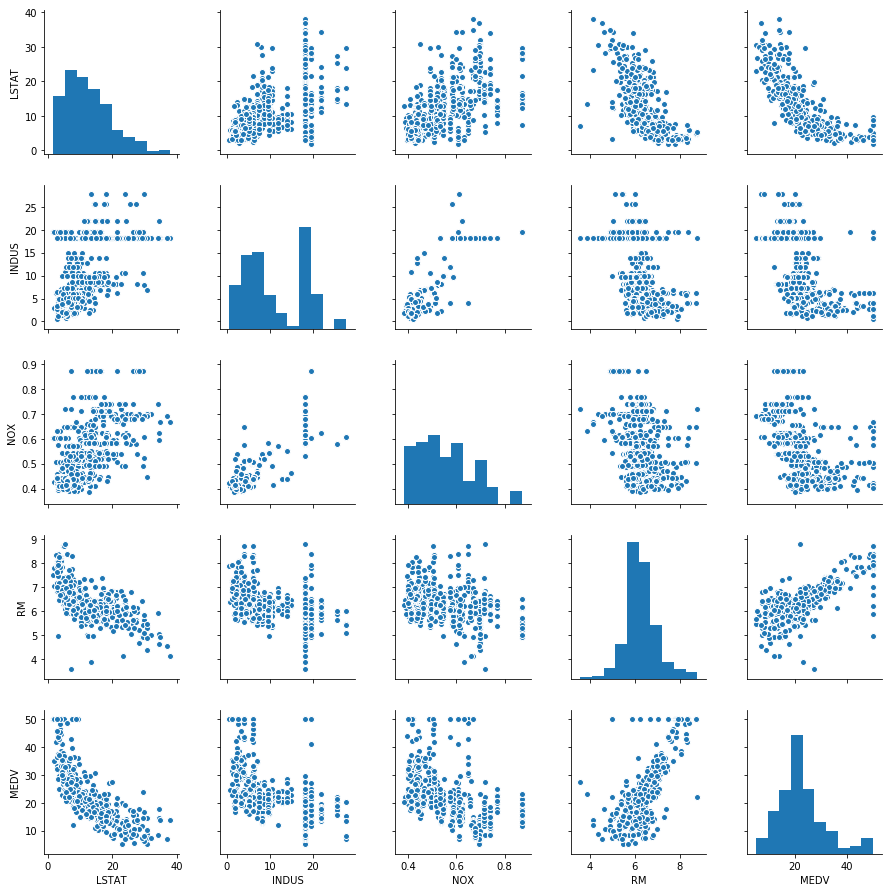

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
plt.show()

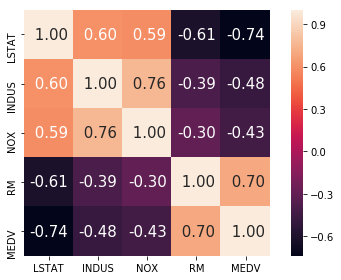

In [19]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
hm = sns.heatmap(cm, 
                cbar=True,
                annot=True,
                square=True,
                fmt=' .2f',
                annot_kws={'size': 15},
                yticklabels=cols,
                xticklabels=cols)
plt.tight_layout()
plt.show()

In [33]:
class LinearRegressionGD(object):
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter
    
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (output - y)
            self.w_[1:] -= self.eta * X.T.dot(errors)
            self.w_[0] -= self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(X)


In [38]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

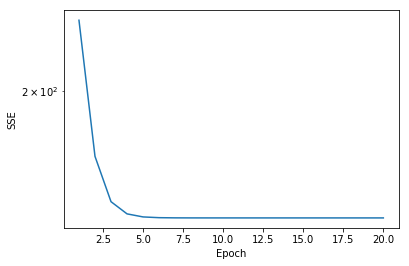

In [41]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.yscale('log')
plt.show()

In [44]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return

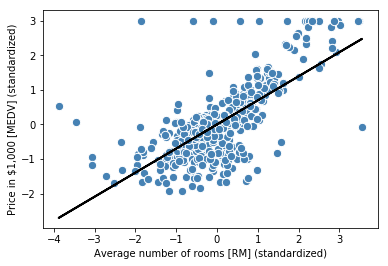

In [45]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1,000 [MEDV] (standardized)')
plt.show()

In [49]:
num_rooms_std = sc_x.transform([[5.0]])
price_std = lr.predict(num_rooms_std)
print('price in $1,000s : %.3f' % sc_y.inverse_transform(price_std))

price in $1,000s : 10.840


In [51]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


In [52]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


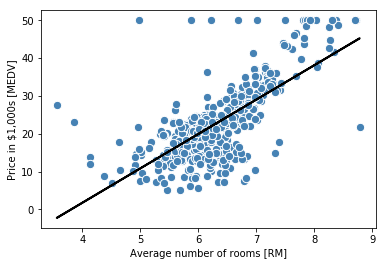

In [53]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1,000s [MEDV]')
plt.show()

In [56]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100,
                         min_samples=50,
                         loss='absolute_loss',
                         residual_threshold=5.0,
                         random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_metric=None, residual_threshold=5.0, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

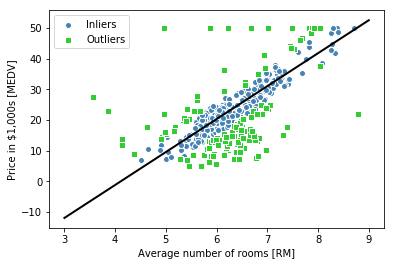

In [58]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], c='steelblue', edgecolor='white', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='limegreen', edgecolor='white', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1,000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [59]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


In [60]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

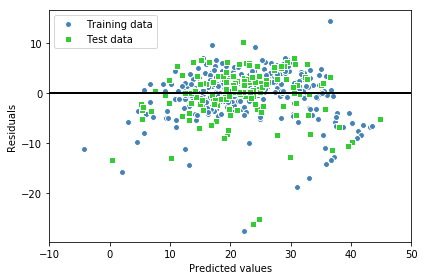

In [61]:
plt.scatter(y_train_pred, y_train_pred - y_train, 
           c='steelblue', marker='o', edgecolor='white', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, 
           c='limegreen', marker='s', edgecolor='white', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()

In [63]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


In [64]:
from sklearn.metrics import r2_score
print('R2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

R2 train: 0.765, test: 0.673


In [65]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=1.0)
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

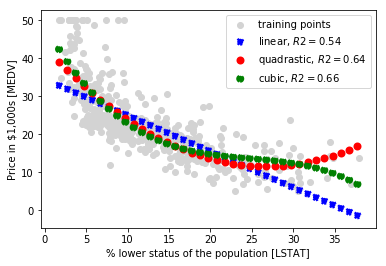

In [68]:
from sklearn.preprocessing import PolynomialFeatures
X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()
quadrastic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadrastic.fit_transform(X)
X_cubic = cubic.fit_transform(X)
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadrastic.fit_transform(X_fit))
quadrastic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

plt.scatter(X, y, label='training points', color='lightgray')
plt.scatter(X_fit, y_lin_fit, label='linear, $R2=%.2f$' % linear_r2, color='blue', lw=2, linestyle=':')
plt.scatter(X_fit, y_quad_fit, label='quadrastic, $R2=%.2f$' % quadrastic_r2, c='red', lw =2, linestyle='-')
plt.scatter(X_fit, y_cubic_fit, label='cubic, $R2=%.2f$' % cubic_r2, c='green', lw=2, linestyle='--')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1,000s [MEDV]')
plt.legend(loc='upper right')
plt.show()

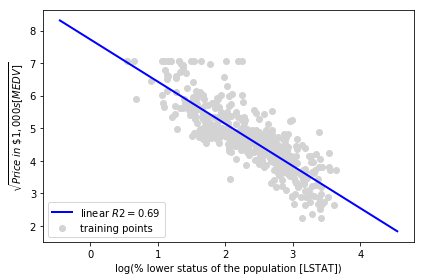

In [77]:
X_log = np.log(X)
y_sqrt = np.sqrt(y)

X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)

y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

plt.scatter(X_log, y_sqrt, label='training points', c='lightgray')
plt.plot(X_fit, y_lin_fit, label='linear $R2=%.2f$' % linear_r2, c='blue', lw=2)
plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1,000s [MEDV]}$')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

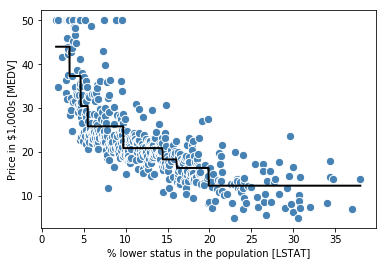

In [78]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status in the population [LSTAT]')
plt.ylabel('Price in $1,000s [MEDV]')
plt.show()

In [83]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000,
                              criterion='mse',
                              random_state=1,
                              n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train:%.3f, test:%.3f' % (mean_squared_error(y_train_pred, y_train),
                                    mean_squared_error(y_test_pred, y_test)))
print('R2 train:%.3f, test:%.3f' % (r2_score(y_train_pred, y_train),
                                   r2_score(y_test_pred, y_test)))


MSE train:1.642, test:11.052
R2 train:0.977, test:0.833


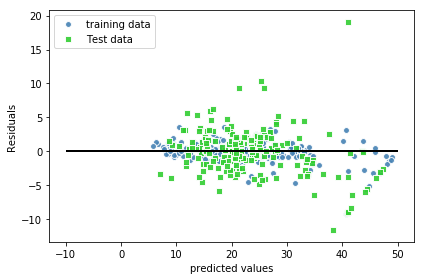

In [87]:
plt.scatter(y_train_pred,
           y_train_pred - y_train,
           c='steelblue',
           edgecolor='white',
           marker='o',
           alpha=0.9,
           s=35,
           label='training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
           c='limegreen',
           edgecolor='white',
           marker='s',
           s=35,
           alpha=0.9,
           label='Test data')
plt.xlabel('predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.tight_layout()
plt.show()

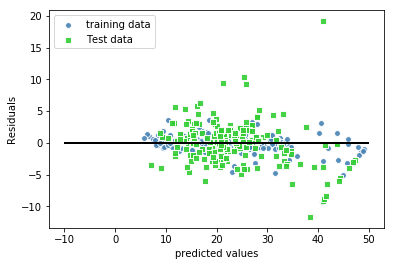

In [88]:
plt.scatter(y_train_pred,
           y_train_pred - y_train,
           c='steelblue',
           edgecolor='white',
           marker='o',
           alpha=0.9,
           s=35,
           label='training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
           c='limegreen',
           edgecolor='white',
           marker='s',
           s=35,
           alpha=0.9,
           label='Test data')
plt.xlabel('predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.show()